In this notebook we process a large part of the glaciers in Patagonia.

In [1]:
# Import script to embed geolocation.
from IPython.display import HTML
import datetime

import sys
sys.path.extend(['/Users/gertmulder/software/rippl_main'])

from rippl.orbit_geometry.read_write_shapes import ReadWriteShapes
from rippl.SAR_sensors.sentinel.sentinel_download import DownloadSentinel
from rippl.processing_templates.general_sentinel_1 import GeneralPipelines

glaciers_shape = [[-73.19091796875, -46.44542749723385],
            [-73.619384765625, -46.33175800051562],
            [-74.102783203125, -46.86019101567025],
            [-73.992919921875, -47.480088463463204],
            [-73.773193359375, -48.19538740833338],
            [-74.014892578125, -48.734455371768206],
            [-74.102783203125, -49.22477272279481],
            [-73.98193359375, -49.63206194128714],
            [-74.06982421875, -50.31039245071913],
            [-73.927001953125, -50.78510168548184],
            [-73.6962890625, -51.32374658474384],
            [-73.399658203125, -52.12674385964288],
            [-73.223876953125, -52.140231201085044],
            [-73.2568359375, -51.6248374617432],
            [-73.05908203125, -50.778155274659234],
            [-73.17993164062499, -50.2542298823062],
            [-72.88330078125, -49.688954878870305],
            [-72.83935546875, -49.1170290407793],
            [-72.92724609375, -48.47292127248782],
            [-73.531494140625, -48.23930899024906],
            [-73.63037109375, -47.82790816919327],
            [-72.916259765625, -47.59875528481801],
            [-72.806396484375, -47.19717795172787],
            [-72.9052734375, -46.6946673077731],
            [-73.19091796875, -46.44542749723385]]
study_area = ReadWriteShapes()
study_area(glaciers_shape)

geojson = study_area.shape

# Try to do the same by creating a shapefile with QGIS, geojson online or a .kml file in google earth.
# study_area.read_kml(kml_path)
# study_area.read_geo_json(geojson_path)
# study_area.read_shapefile(shapefile_path)

The next step in the processing is selection of the right track, as the Sentinel-1 satellite will cover the area on both
ascending and descending tracks. However, to do so, we will have to define the start and end date of our data search, 
because the satellite is not always acquiring data. 
Next search will give a small oversight of the available tracks during our period of interest. In our case we will 
search one week before and one week after the earthquake.

Watch out with extending the search window, this can result in a lot of images. Note that every downloaded file will take approximately 4GB of disk space!

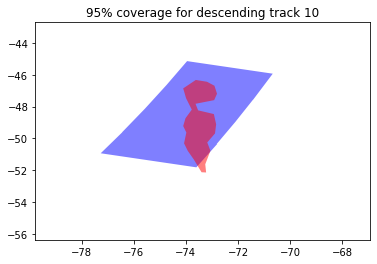

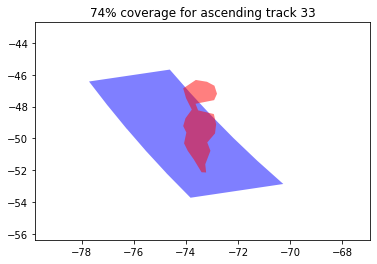

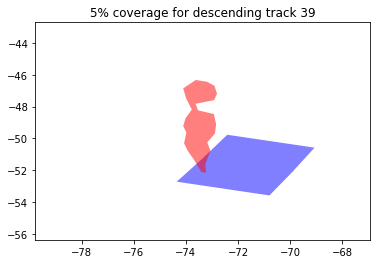

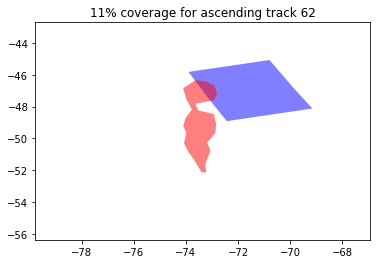

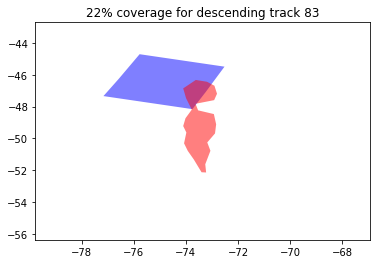

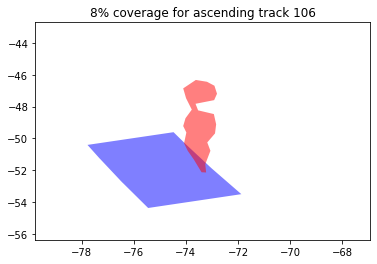

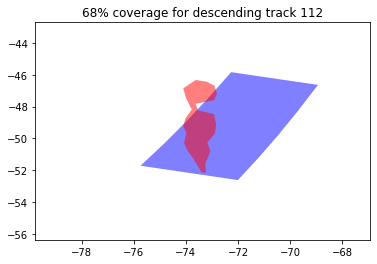

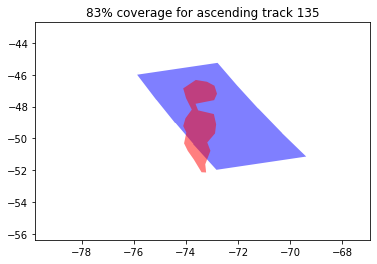

Summary statistics for Sentinel-1 search:
Stack for descending track 10 contains 1 images with 95% coverage of area of interest
Stack for ascending track 33 contains 1 images with 74% coverage of area of interest
Stack for descending track 39 contains 7 images with 5% coverage of area of interest
Stack for ascending track 62 contains 7 images with 11% coverage of area of interest
Stack for descending track 83 contains 7 images with 22% coverage of area of interest
Stack for ascending track 106 contains 6 images with 8% coverage of area of interest
Stack for descending track 112 contains 6 images with 68% coverage of area of interest
Stack for ascending track 135 contains 7 images with 83% coverage of area of interest

Full list of images for track 10:
2018-03-25T09:52:10 with a coverage of 95% consists of SAR products:
          S1B_IW_SLC__1SDV_20180325T095145_20180325T095210_010186_012821_7714
          S1B_IW_SLC__1SDV_20180325T095120_20180325T095147_010186_012821_A37D
          S1B

In [2]:
# First we search using a time window

# Track and data type of Sentinel data
mode = 'IW'
product_type = 'SLC'
polarisation = 'VV'

# First we check using a time window
start_date = datetime.datetime(year=2018, month=3, day=22)
end_date = datetime.datetime(year=2018, month=6, day=12)

find_track = DownloadSentinel(start_date=start_date, end_date=end_date, shape=study_area.shape, sensor_mode=mode,
                              polarisation=polarisation)
find_track.sentinel_search_ASF()
find_track.summarize_search_results(plot_cartopy=False, buffer=2)

After selection of the right track we can start the actual download of the images. In our case we use track 135.

This will download our data automatically to our radar database. Additionally, it will download the precise orbit files.
These files are created within a few weeks after the data acquisition and define the satellite orbit within a few cm
accuracy. These orbits are necessary to accurately define the positions of the radar pixels on the ground later on
in the processing.

In [2]:
# Track and data type of Sentinel data
mode = 'IW'
product_type = 'SLC'
polarisation = 'VV'

from rippl.processing_templates.general_sentinel_1 import GeneralPipelines

# Create the list of the 4 different stacks.
track_no = 135
stack_name = 'glaciers_Patagonia'
# For every track we have to select a master date. This is based on the search results earlier.
# Choose the date with the lowest coverage to create an image with only the overlapping parts.
master_date = datetime.datetime(year=2018, month=6, day=7)

# Number of processes for parallel processing. Make sure that for every process at least 2GB of RAM is available
no_processes = 4

s1_processing = GeneralPipelines(processes=no_processes)
s1_processing.download_sentinel_data(start_date=start_date, end_date=end_date, track=track_no,
                                           polarisation=polarisation, shapefile=study_area.shape, data=True, source='ASF')
s1_processing.create_sentinel_stack(start_date=start_date, end_date=end_date, master_date=master_date, cores=no_processes,
                                          track=track_no,stack_name=stack_name, polarisation=polarisation,
                                          shapefile=study_area.shape, mode=mode, product_type=product_type)

# Finally load the stack itself. If you want to skip the download step later, run this line before other steps!
s1_processing.read_stack(start_date=start_date, end_date=end_date, stack_name=stack_name)

wget -c --http-user=gertmulder --http-password=Radar2016 --no-check-certificate "https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_SLC__1SDV_20180511T161620_20180511T161639_021859_025BF8_9FF0.zip" -O /Users/gertmulder/SAR_processing/radar_database/Sentinel-1/s1_dsc_t87/IW_SLC__1SDV_VVVH/20180511/S1A_IW_SLC__1SDV_20180511T161620_20180511T161639_021859_025BF8_9FF0.zip
wget -c --http-user=gertmulder --http-password=Radar2016 --no-check-certificate "https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_SLC__1SDV_20180511T161552_20180511T161622_021859_025BF8_1292.zip" -O /Users/gertmulder/SAR_processing/radar_database/Sentinel-1/s1_dsc_t87/IW_SLC__1SDV_VVVH/20180511/S1A_IW_SLC__1SDV_20180511T161552_20180511T161622_021859_025BF8_1292.zip
Loading available orbit data files
Finished loading date files
S1B_IW_SLC__1SDV_20180505T161525_20180505T161552_010788_013B7D_25D2.zip
S1B_IW_SLC__1SDV_20180423T161524_20180423T161551_010613_0135DD_33F0.zip
S1A_IW_SLC__1SDV_20180511T161620_20180511T161639_021859_025BF8_

To define the location of the radar pixels on the ground we need the terrain elevation. Although it is possible to 
derive terrain elevation from InSAR data, our used Sentinel-1 dataset is not suitable for this purpose. Therefore, we
download data from an external source to create a digital elevation model (DEM). In our case we use SRTM data. 

However, to find the elevation of the SAR data grid, we have to resample the data to the radar grid first to make it
usable. This is done in the next steps.

In [3]:
# Some basic settings for DEM creation.
dem_buffer = 0.1        # Buffer around radar image where DEM data is downloaded
dem_rounding = 0.1      # Rounding of DEM size in degrees
dem_type = 'SRTM3'      # DEM type of data we download (SRTM1, SRTM3 and TanDEM-X are supported)

# Define both the coordinate system of the full radar image and imported DEM
s1_processing.create_radar_coordinates()
s1_processing.create_dem_coordinates(dem_type=dem_type)

# Download external DEM
s1_processing.download_external_dem(buffer=dem_buffer, rounding=dem_rounding, n_processes=no_processes)

Using the obtained elevation model the exact location of the radar pixels in cartesian (X,Y,Z) and geographic (Lat/Lon)
can be derived. This is only done for the master or reference image. This process is referred to as geocoding.

In [4]:
# Geocoding of image
s1_processing.geocoding()

Processing pipeline block 1 out of 1
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Processing pipeline block 1 out of 1
Start processing dem block 1 out of 12 [2 of total 168] for /Users/gertmulder/SAR_processing/radar_data_stacks/Sentinel-1/Hawaii_may_2018_descending/20180505/slice_505_swath_2
Processing image region from lines 739 > 861 and pixels 1 > 

The information from the geocoding can directly be used to find the location of the master grid pixels in the slave
grid images. This process is called coregistration. Because the orbits are not exactly the same with every satellite 
overpass but differ hundreds to a few thousand meters every overpass, the grids are slightly shifted with respect to 
each other. These shift are referred to as the spatial baseline of the images. To correctly overlay the master and slave
images the software coregisters and resamples to the master grid.

To do so the following steps are done:
1. Coregistration of slave to master image
2. Deramping the doppler effects due to TOPs mode of Sentinel-1 satellite
3. Resampling of slave image
4. Reramping resampled slave image.

Due to the different orbits of the master and slave image, the phase of the radar signal is also shifted. We do not 
know the exact shift of the two image, but using the geometry of the two images we can estimate the shift of the phase
between different pixels. Often this shift is split in two contributions:
1. The flat earth phase. This phase is the shift in the case the earth was a perfect ellipsoid
2. The topographic phase. This is the phase shift due to the topography on the ground.
In our processing these two corrections are done in one go.

In [5]:
# Next step applies resampling and phase correction in one step.
# Polarisation
s1_processing.geometric_coregistration_resampling(polarisation=polarisation, output_phase_correction=True)

Processing pipeline block 1 out of 2
Start processing geometric_coregistration block 1 out of 8 [2 of total 360] for /Users/gertmulder/SAR_processing/radar_data_stacks/Sentinel-1/Hawaii_may_2018_descending/20180423/slice_500_swath_2
Processing image region from lines 821 > 1025 and pixels 1 > 24456 with size 205 x 24456 from total image size 1454 x 24456
Start processing geometric_coregistration block 1 out of 6 [1 of total 360] for /Users/gertmulder/SAR_processing/radar_data_stacks/Sentinel-1/Hawaii_may_2018_descending/20180423/slice_506_swath_1
Processing image region from lines 981 > 1225 and pixels 1 > 20458 with size 245 x 20458 from total image size 1454 x 20458
Start processing geometric_coregistration block 1 out of 8 [0 of total 360] for /Users/gertmulder/SAR_processing/radar_data_stacks/Sentinel-1/Hawaii_may_2018_descending/20180505/slice_502_swath_2
Processing image region from lines 616 > 820 and pixels 1 > 24456 with size 205 x 24456 from total image size 1454 x 24456
Star

Now we can create calibrated amplitudes, interferograms and coherences.

In [6]:
for dist in [50, 100, 200]:

    # The actual creation of the calibrated amplitude images
    s1_processing.create_ml_coordinates(standard_type='oblique_mercator', dx=dist, dy=dist, buffer=0, rounding=0)
    s1_processing.prepare_multilooking_grid(polarisation)
    s1_processing.create_calibrated_amplitude_multilooked(polarisation)
    s1_processing.create_output_tiffs_amplitude()

    s1_processing.create_ifg_network(temporal_baseline=15)
    s1_processing.create_interferogram_multilooked(polarisation)
    s1_processing.create_coherence_multilooked(polarisation)

    # Create output geotiffs
    s1_processing.create_output_tiffs_coherence_ifg()

    # Create lat/lon/incidence angle/DEM for multilooked grid.
    s1_processing.create_geometry_mulitlooked()
    s1_processing.create_output_tiffs_geometry()

Finished concatenation crop of /Users/gertmulder/SAR_processing/radar_data_stacks/Sentinel-1/Hawaii_may_2018_descending/20180505
Processing pipeline block 1 out of 1
Start processing reproject block 1 out of 108 [1 of total 108] for /Users/gertmulder/SAR_processing/radar_data_stacks/Sentinel-1/Hawaii_may_2018_descending/20180505
Processing image region from lines 11301 > 11413 and pixels 1 > 44435 with size 113 x 44435 from total image size 12186 x 44435
Start processing reproject block 1 out of 108 [0 of total 108] for /Users/gertmulder/SAR_processing/radar_data_stacks/Sentinel-1/Hawaii_may_2018_descending/20180505
Processing image region from lines 5312 > 5424 and pixels 1 > 44435 with size 113 x 44435 from total image size 12186 x 44435
Start processing reproject block 1 out of 108 [3 of total 108] for /Users/gertmulder/SAR_processing/radar_data_stacks/Sentinel-1/Hawaii_may_2018_descending/20180505
Processing image region from lines 1131 > 1243 and pixels 1 > 44435 with size 113 x 4